# Бейзлайн для задачи AIJ Multi-Agent AI

Данный ноутбук содержит реализацию [VDN](https://arxiv.org/abs/1706.05296) - кооперативного 
мульти-агентного алгоритма обучения с подкреплением. VDN основан на предпосылке
о линейном разложении общей награды агентов, таким образом, общая награда
всех агентов представлена в виде суммы индивидуальных наград.
Несмотря на то, что данная предпосылка ограничивает класс обучаемых стратегий
только кооперативными вариантами, VDN все же является хорошим бейзлайном для 
многих задач мульти-агентного обучения с подкреплением.

Данный бейзлайн позволяет получить целевую метрику (Mean Focal Score) около
42 при ее сабмите в тестовую систему (Случайная политика, для сравнения, 
получает ~4).

Главным результатом работы ноутбука будет создание директории `submission_vdn`, которую 
необходимо запаковать в .zip архив и отправить в тестирующую систему.

Мы рекомендуем запускать тесты на своих решениях, прежде чем отправлять их в систему.

In [1]:
import os
from typing import Any, Dict, List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import yaml
from aij_multiagent_rl.agents import BaseAgent, RandomAgent
from aij_multiagent_rl.env import AijMultiagentEnv
from math import ceil
from omegaconf import DictConfig
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Создаем корректную структуру сабмишена


Правильная структура директории решения представлена ниже:

```
.
├── utils                          # Директория с модулями, необходимыми для класса агента (опционально)
├── model.py                       # Скрипт с реализацией класса агента(ов) и фабричного метода
└── agents                         # Директория с артефактами агентов (название фисировано) 
    ├── agent_0                    # Артефакты отдельного агента (название произвольное)
        ├── agent_config.yaml      # Конфиг агента для фабричного метода (название фиксировано)
        └── weights_agent_0.pth    # Пример артефакта (веса модели или любые произвольные файлы)
    ...                            # Агентов может быть и больше 8
    └── agent_n
        ├── agent_config.yaml    
        └── weights_agent_n.pth
```

In [2]:
submission_dir = 'submission_vdn'

required_dirs = [
    f'{submission_dir}/agents',
    f'{submission_dir}/utils'
]
for d in required_dirs:
    if not os.path.exists(d):
        os.makedirs(d)

# Вспомогательные функции для Torch

Данные вспомогательные функции будут записаны в файл `submission_vdn/utils/utils.py`.

In [3]:
%%writefile submission_vdn/utils/utils.py
import torch
import numpy as np


def from_numpy(device, array, dtype=np.float32):
    array = array.astype(dtype)
    tensor = torch.from_numpy(array)
    return tensor.to(device)


def to_numpy(tensor):
    return tensor.to('cpu').detach().numpy()


def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

Writing submission_vdn/utils/utils.py


# Функция сэмплирования из среды

Далее реализован параллельный сэмплинг данных из среды `AijMultiagentEnv` при помощи нескольких агентов. В ходе работы функции вызываются следующие методы:

1) `reset_state()` - перезагрузка внутреннего состояния агента с началом эпизода
2) `get_action()` - получение действия из композитного наблюдения

In [4]:
def sample_rollouts(
    n_rollouts: int,
    env: AijMultiagentEnv,
    agents: Dict[str, BaseAgent],
    verbose: Optional[bool] = False
) -> List[List[Dict[str, Any]]]:
    rollouts = []
    for _ in tqdm(range(n_rollouts), disable=not verbose):
        rollout = []
        for agent in agents.values():
            agent.reset_state()
        observations, infos = env.reset()
        done = False
        while not done:
            actions = {name: agent.get_action(observation=observations[name])
                       for name, agent in agents.items() if name in env.agents}
            next_observations, rewards, terminations, truncations, next_infos = env.step(actions)
            transition = {
                'observations': observations,
                'next_observations': next_observations,
                'actions': actions,
                'rewards': rewards,
                'terminations': terminations,
                'truncations': truncations
            }
            observations = next_observations
            done = all(truncations.values()) or all(terminations.values())
            rollout.append(transition)
        rollouts.append(rollout)
    return rollouts

# Сэмплирование эпизодов при помощи случайных агентов

In [5]:
def get_mean_agent_return(batch):
    mean_rews = []
    for path in batch:
        ep_tot_rew = [sum(t['rewards'].values()) for t in path]
        ep_tot_rew = sum(ep_tot_rew)
        mean_rews.append(ep_tot_rew / 8)
    return np.mean(mean_rews)


env = AijMultiagentEnv()
example_agents = {a: RandomAgent() for a in env.possible_agents}
example_batch = sample_rollouts(n_rollouts=10, env=env, agents=example_agents, verbose=True)
print(f'Mean agent return for RandomAgent: {get_mean_agent_return(example_batch)}')

100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.33s/it]

Mean agent return for RandomAgent: 5.75


# Создаем буфер данных

Создаем простой буфер данных для хранения эпизодов симуляции

In [6]:
class ReplayBuffer(Dataset):

    def __init__(
        self,
        n_transitions: int
    ):
        self.rollouts = []
        self.n_transitions = n_transitions
        self.lengths = None

    def add_batch(self, rollouts):
        self.rollouts.extend(rollouts)
        self._evict()
        self.lengths = [len(r) for r in self.rollouts]

    def _evict(self) -> None:
        while len(self) > self.n_transitions:
            self.rollouts.pop(0)

    def __len__(self):
        if len(self.rollouts) == 0:
            return 0
        else:
            return sum([len(r) for r in self.rollouts])

    def __getitem__(self, idx: int) -> Dict[str, Dict[str, Union[np.ndarray, int]]]:
        c_lengths = np.cumsum(self.lengths)
        r_ind = np.argwhere(c_lengths > idx).min()
        r_ind_last = 0
        if r_ind > 0:
            r_ind_last = c_lengths[r_ind - 1]
        t_ind = idx - r_ind_last
        transition = self.rollouts[r_ind][t_ind]
        item = {
            **transition,
            'rollout_index': r_ind,
            'transition_index': t_ind
        }
        return item

In [7]:
def collate_fn(data: List[Dict[str, Any]]) -> Dict[str, Any]:
    collated_data = {k: {} for k in data[0].keys()}
    for a in data[0]['observations'].keys():
        collated_data['observations'][a] = {}
        collated_data['observations'][a]['image'] = np.array(
            [d['observations'][a]['image'] for d in data])
        collated_data['observations'][a]['proprio'] = np.array(
            [d['observations'][a]['proprio'] for d in data])
        collated_data['next_observations'][a] = {}
        collated_data['next_observations'][a]['image'] = np.array(
            [d['next_observations'][a]['image'] for d in data])
        collated_data['next_observations'][a]['proprio'] = np.array(
            [d['next_observations'][a]['proprio'] for d in data])
        collated_data['actions'][a] = np.array([d['actions'][a] for d in data])
        collated_data['rewards'][a] = np.array([d['rewards'][a] for d in data])
        collated_data['terminations'][a] = np.array([d['terminations'][a] for d in data])
        collated_data['truncations'][a] = np.array([d['truncations'][a] for d in data])
    collated_data['rollout_index'] = np.array([d['rollout_index'] for d in data])
    collated_data['transition_index'] = np.array([d['transition_index'] for d in data])
    return collated_data

# Создаем пример dataloader

Он понадобится для демонстрации размерностей основных данных

In [8]:
example_buffer = ReplayBuffer(100000)
example_buffer.add_batch(example_batch)

example_dataloader = DataLoader(
    dataset=example_buffer,
    batch_size=32,
    num_workers=0,
    collate_fn=collate_fn,
    shuffle=True,
)

In [9]:
sample = next(iter(example_dataloader))

print(f"Image observation shape: {sample['observations']['agent_0']['image'].shape}")
print(f"Proprio observation shape: {sample['observations']['agent_0']['proprio'].shape}")
print(f"Actions shape: {sample['actions']['agent_0'].shape}")
print(f"Rewards shape: {sample['rewards']['agent_0'].shape}")
print(f"Terminations shape: {sample['terminations']['agent_0'].shape}")

Image observation shape: (32, 60, 60, 3)
Proprio observation shape: (32, 7)
Actions shape: (32,)
Rewards shape: (32,)
Terminations shape: (32,)


# Сетка критик

Параграф ниже реализует сеть-критик, которая принимает на вход композитное визуально-проприоцептивное наблюдение и аппроксимирует Q-значения для каждого возможного действия.

In [10]:
%%writefile submission_vdn/utils/networks.py
import torch
from torch import nn


class QCNN(nn.Module):

    def __init__(self, in_channels, acs_dim):
        super(QCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=48, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.mlp = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
        )
        self.head = nn.Sequential(
            nn.Linear(1600, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, acs_dim),
        )

    def forward(self, image: torch.Tensor, proprio: torch.Tensor) -> torch.Tensor:
        # Image stream
        bs, h, w, c = image.shape
        image = image.permute(0, 3, 1, 2)
        image = image / 255.
        image_repr = self.cnn(image)
        # Proprio stream
        proprio_repr = self.mlp(proprio)
        # Head
        hidden = torch.cat([image_repr, proprio_repr], 1)
        q_vals = self.head(hidden)
        return q_vals


Writing submission_vdn/utils/networks.py


# Создаем VDN агента

Ниже определим класс VDN агента, стоит отметить. что:

Класс агента должен поддерживать следующие методы:
- `.load()` - подгрузка агента из директории
- `.get_action()` - получение действия из композитного наблюдения
- `.reset_state()` - перезагрузка внутреннего состояния агента с началом эпизода

Класс агента должен быть отнаследован от абстрактного класса `aij_multiagent_rl.agent.BaseAgent`

Файл `model.py` должен содержать фабричный метод агента как показано ниже

In [11]:
%%writefile submission_vdn/model.py
import os
from copy import deepcopy
from typing import Dict

import numpy as np
import torch
from aij_multiagent_rl.agents import BaseAgent
from omegaconf import DictConfig
from torch import nn
from utils.networks import QCNN
from utils.utils import from_numpy, get_device, to_numpy


class DQNAgent(BaseAgent, nn.Module):
    def __init__(
        self,
        model,
        device,
        eval_mode,
        warmup_steps=20000,
        eps_start=0.2,
        eps_decay=0.995,
        eps_decay_every=5000,
        acs_dim=9,
        seed=None
    ):
        super(DQNAgent, self).__init__()
        self.device = device
        self.warmup_steps = warmup_steps
        self.eval_mode = eval_mode
        self.steps_made = 0
        self.n_target_updates = 0
        self.current_eps = eps_start
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_decay_every = eps_decay_every
        self.acs_dim = acs_dim
        self.model = model.to(device)
        self.target_model = deepcopy(self.model)
        self.target_model.to(device)
        if seed is None:
            seed = np.random.randint(0, int(1e6), 1)
        self.rng = np.random.default_rng(seed)

    def reset_state(self) -> None:
        pass

    def load(self, ckpt_dir: str) -> None:
        self.load_state_dict(
            torch.load(
                os.path.join(ckpt_dir, "module.pth"),
                map_location=get_device()
            )
        )

    def save(self, ckpt_dir: str) -> None:
        torch.save(self.state_dict(), os.path.join(ckpt_dir, 'module.pth'))

    def _eps(self):
        if self.steps_made < self.warmup_steps:
            return 1.
        else:
            if self.steps_made % self.eps_decay_every == 0:
                self.current_eps *= self.eps_decay
            return self.current_eps

    def _get_action(self, observation: Dict[str, np.ndarray]) -> int:
        image = from_numpy(self.device, np.expand_dims(observation['image'], 0))
        proprio = from_numpy(self.device, np.expand_dims(observation['proprio'], 0))
        qvals = self.model.forward(image=image, proprio=proprio)
        qvals = to_numpy(qvals)
        return np.argmax(qvals)

    def update_target_network(self, tau: float) -> None:
        self.n_target_updates += 1
        for target_param, param in zip(
                self.target_model.parameters(), self.model.parameters()
        ):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def forward(self, image: torch.Tensor, proprio: torch.Tensor) -> torch.Tensor:
        return self.model.forward(image, proprio)

    @torch.no_grad()
    def forward_target(self, image: torch.Tensor, proprio: torch.Tensor) -> torch.Tensor:
        return self.target_model.forward(image, proprio)

    def get_action(self, observation: Dict[str, np.ndarray]) -> int:
        if not self.eval_mode:
            self.steps_made += 1
        eps = self._eps()
        u = self.rng.uniform(0, 1, 1).item()
        if u < eps:
            acs = self.rng.integers(0, self.acs_dim, 1).item()
        else:
            acs = self._get_action(observation=observation)
        return acs


def get_agent(config: DictConfig) -> BaseAgent:
    agent = DQNAgent(
        device=get_device(),
        model=QCNN(in_channels=config.in_channels, acs_dim=config.acs_dim),
        eval_mode=config.eval_mode,
        warmup_steps=config.warmup_steps,
        eps_start=config.eps_start,
        eps_decay=config.eps_decay,
        eps_decay_every=config.eps_decay_every,
        acs_dim=config.acs_dim,
        seed=config.seed
    )
    agent.steps_made = config.ckpt_steps_made
    agent.current_eps = config.ckpt_eps
    return agent


Writing submission_vdn/model.py


# Импортируем необходимые модули

Примечание: как можно видеть ниже, директория с вашими файлами решения будет использована как точка входа для импорта фабричного метода `get_agent`.

In [12]:
import sys
sys.path.insert(1, submission_dir)
from model import DQNAgent, get_agent
from utils.utils import get_device, from_numpy
from utils.networks import QCNN

# Определим VDN Trainer

Основная логика обновления весов алгоритма VDN реализована в методе `update()`

In [13]:
class VDNTrainer(nn.Module):
    def __init__(
        self,
        agents: Dict[str, DQNAgent],
        learning_rate: float,
        gamma: float = 0.99,
        td_criterion=F.smooth_l1_loss,
        tau: float = 0.005
    ):
        super(VDNTrainer, self).__init__()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.td_criterion = td_criterion
        self.tau = tau
        self.n_updates = 0
        self.last_logs = {}

        # Set agents
        self.agents = nn.ModuleDict(agents)
        self.devices = {n: a.device for n, a in self.agents.items()}

        # Define optimizer
        self.optimizer = optim.Adam(
            params=(self._get_params()),
            lr=self.learning_rate
        )

    def _get_params(self):
        params = []
        ids = []
        for a in self.agents.values():
            model_id = id(a.model)
            if model_id not in ids:
                params.extend(list(a.model.parameters()))
                ids.append(model_id)
        return params

    def update_target_networks(self) -> None:
        for a in self.agents.values():
            a.update_target_network(tau=self.tau)

    def forward(
        self,
        images: Dict[str, torch.Tensor],
        proprio: Dict[str, torch.Tensor],
    ) -> Dict[str, torch.Tensor]:
        output = {}
        for name, agent in self.agents.items():
            qvals = agent.forward(images[name], proprio[name])
            output[name] = qvals
        return output

    @torch.no_grad()
    def forward_target(
        self,
        images: Dict[str, torch.Tensor],
        proprio: Dict[str, torch.Tensor],
    ) -> Dict[str, torch.Tensor]:
        output = {}
        for name, agent in self.agents.items():
            qvals = agent.forward_target(images[name], proprio[name])
            output[name] = qvals
        return output

    def save(self, dir: str, config: dict) -> None:
        for name, agent in self.agents.items():
            agent_dir = os.path.join(dir, name)
            if not os.path.exists(agent_dir):
                os.makedirs(agent_dir)
            agent.save(ckpt_dir=agent_dir)
            with open(os.path.join(agent_dir, 'agent_config.yaml'), 'w') as outfile:
                yaml.dump(config, outfile, default_flow_style=False)

    def update(self, sample: Dict[str, Any]) -> Dict[str, float]:

        # Get device
        devs = self.devices

        # Unpack data
        obs_image = {k: from_numpy(devs[k], v['image']) 
                     for k, v in sample['observations'].items()}
        next_obs_image = {k: from_numpy(devs[k], v['image']) 
                          for k, v in sample['next_observations'].items()}
        obs_proprio = {k: from_numpy(devs[k], v['proprio']) 
                       for k, v in sample['observations'].items()}
        next_obs_proprio = {k: from_numpy(devs[k], v['proprio']) 
                            for k, v in sample['next_observations'].items()}
        actions = {k: from_numpy(devs[k], v) for k, v in sample['actions'].items()}
        rewards = {k: from_numpy(devs[k], v) / 10. for k, v in sample['rewards'].items()}
        terminations = {k: from_numpy(devs[k], v) for k, v in sample['terminations'].items()}

        shared_rewards = torch.cat([r.unsqueeze(-1) for r in rewards.values()], axis=-1)
        shared_rewards = shared_rewards.sum(dim=-1, keepdims=True)

        # construct target q-values
        qa_tp1_target = self.forward_target(next_obs_image, next_obs_proprio)
        with torch.no_grad():
            qa_tp1_model = self.forward(next_obs_image, next_obs_proprio)

        # Select maximum value by agent and sum
        q_tp1 = []
        for name, qa_tp1_t_a in qa_tp1_target.items():
            qa_tp1_m_a = qa_tp1_model[name]
            q_tp1_a = torch.gather(qa_tp1_t_a, 1,
                                   qa_tp1_m_a.argmax(dim=1, keepdims=True))
            term = terminations[name].unsqueeze(1)
            q_tp1_a = q_tp1_a * torch.logical_not(term)
            q_tp1.append(q_tp1_a)
        q_tp1 = torch.cat(q_tp1, axis=-1).sum(dim=-1, keepdims=True)

        # Create targets
        q_targets = shared_rewards + self.gamma * q_tp1

        # Calculate outputs
        qa_t = self.forward(obs_image, obs_proprio)

        # Select qvalue by action
        q_t = []
        for name, qa_t_a in qa_t.items():
            acs_a = actions[name]
            q_t_a = torch.gather(qa_t_a, 1,
                                 acs_a.to(torch.long).unsqueeze(1))
            q_t.append(q_t_a)
        q_t = torch.cat(q_t, axis=-1).sum(dim=-1, keepdims=True)

        # compute loss
        loss = self.td_criterion(q_t, q_targets)

        # performing gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.n_updates += 1

        return {
            'dqn_loss': loss.item(),
            'mean_q_value': q_t.mean().item(),
            'n_updates': self.n_updates,
            'mean_shared_reward': shared_rewards.mean().item(),
            'mean_agents_steps': np.mean([a.steps_made for a in self.agents.values()]).item(),
            'mean_target_updates': np.mean([a.n_target_updates for a in self.agents.values()]).item(),
            'mean_eps': np.mean([a.current_eps for a in self.agents.values()]).item()
        }

# Подготовим процесс обучения

In [14]:
config = DictConfig({
    'warmup_steps': 20000,
    'eps_start': 0.2,
    'eps_decay': 0.996,
    'eps_decay_every': 1000,
    'acs_dim': 9,
    'batch_size': 32,
    'update_every': 4,
    'buffer_size': 100000,
    'initial_batch_episodes': 20,
    'learning_rate': 0.00005,
    'gamma': 0.99,
    'target_updates_freq': 15,
    'episodes_per_iter': 2,
    'iter_per_save': 50,
    'n_iters': 310,
    'tau': 0.005,
    'output_dir': f'{submission_dir}/agents',
    'in_channels': 3
})

# Инициализация симулятора и буфера данных

In [15]:
env = AijMultiagentEnv()
buffer = ReplayBuffer(config.buffer_size)

# Инициализация VDN trainer

Стоит отметить, что все агенты делят веса сетки критика, такая архитектура улучшает сходимость алгоритма и сокращает количество обучаемых параметров.

In [16]:
device = get_device()

model = QCNN(in_channels=config.in_channels, acs_dim=config.acs_dim)

agents = {a: DQNAgent(
    device=device,
    model=model,
    eval_mode=False,
    warmup_steps=config.warmup_steps,
    eps_start=config.eps_start,
    eps_decay=config.eps_decay,
    eps_decay_every=config.eps_decay_every,
    acs_dim=config.acs_dim
) for a in env.possible_agents}

trainer = VDNTrainer(
    agents=agents,
    learning_rate=config.learning_rate,
    gamma=config.gamma,
    tau=config.tau
)

# Заполняем буфер изначальными рандомизированными данными

In [17]:
initial_batch = sample_rollouts(
    n_rollouts=config.initial_batch_episodes, env=env, agents=trainer.agents, verbose=True
)
buffer.add_batch(initial_batch)
dataloader = DataLoader(
    dataset=buffer,
    batch_size=config.batch_size,
    num_workers=0,
    collate_fn=collate_fn,
    shuffle=True,
)
print(f'Initial Buffer Size: {len(buffer)}')

100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.60s/it]

Initial Buffer Size: 20000


# Запускаем обучение

In [18]:
training_logs = []


for it in tqdm(range(config.n_iters)):

    # Sample batch
    batch = sample_rollouts(env=env, agents=trainer.agents,
                            n_rollouts=config.episodes_per_iter, verbose=False)
    batch_size = sum([len(e) for e in batch])

    # Add to buffer
    buffer.add_batch(rollouts=batch)
    data_iter = iter(dataloader)

    # Launch update loop
    iter_n_updates = max(1, batch_size // config.update_every)
    iter_logs = []
    
    for _ in range(iter_n_updates):
        try:
            sample = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            sample = next(data_iter)
        logs = trainer.update(sample)
        if trainer.n_updates % config.target_updates_freq == 0:
            trainer.update_target_networks()
        iter_logs.append(logs)

    # Collect Logs
    mean_agent_reward = get_mean_agent_return(batch)
    mean_episode_length = batch_size / config.episodes_per_iter
    iter_logs = {
        'mean_agent_reward': mean_agent_reward,
        'mean_episode_length': mean_episode_length,
        'batch_size': batch_size,
        'iter_n_updates': iter_n_updates,
        'buffer_size_transitions': len(buffer),
        'buffer_size_episodes': len(buffer.rollouts),
        **{k: np.mean([l[k] for l in iter_logs]) for k in iter_logs[0].keys()},
    }
    training_logs.append(iter_logs)

    # Write artifacts
    if it > 0 and it % config.iter_per_save == 0:
        ckpt_steps_made = min([a.steps_made for a in trainer.agents.values()])
        ckpt_eps = min([a.current_eps for a in trainer.agents.values()])
        save_config = {
            **config,
            'eval_mode': True,
            'ckpt_steps_made': ckpt_steps_made,
            'ckpt_eps': ckpt_eps,
            'seed': 42
        }
        trainer.save(dir=config.output_dir, config=save_config)

100%|███████████████████████████████████████| 310/310 [3:01:09<00:00, 35.06s/it]


# Визуализация логов обучения

Необходимо отметить, что в данном случае средняя награда обучаемых агентов `Mean Agent Reward` не обязательно должна совпадать с целевой метрикой `Mean Focal Score`, вычисляемой тестовой системой. Основная причина заключается в том, что на фазе обучения агенты играют с симметричными агентами, тогда как в тестовой системе симуляции проводятся совместно с различными ботами со скрытыми от Участников стратегиями.

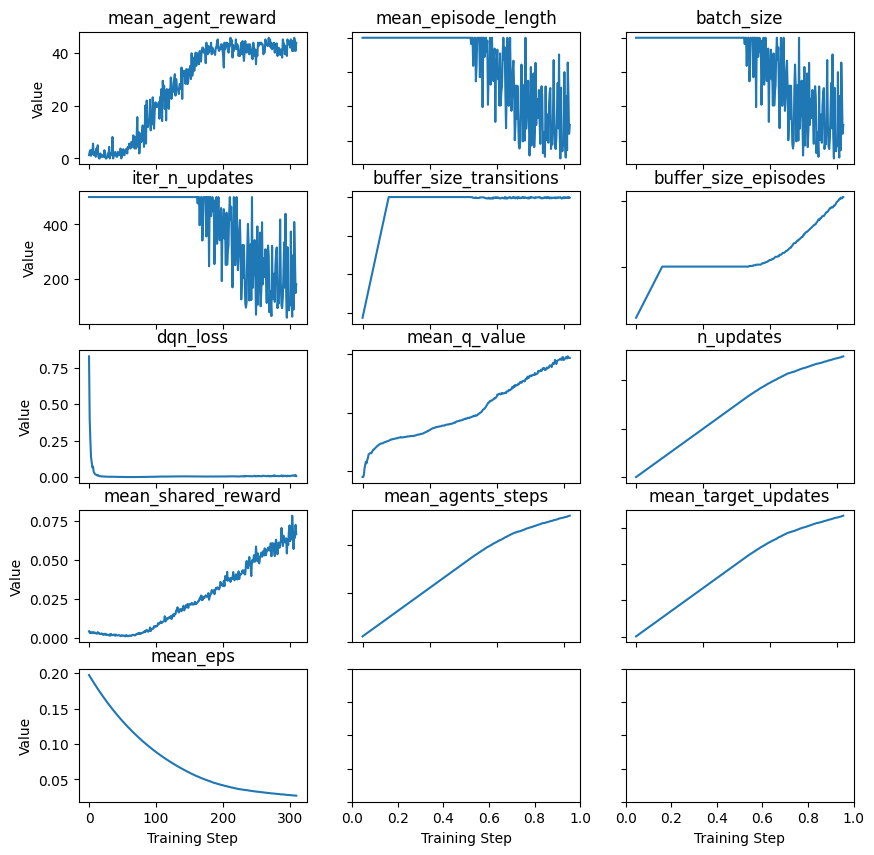

In [19]:
ncols = 3
n_graphs = len(training_logs[-1].keys())
nrows = ceil(n_graphs / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10))
for i, key in enumerate(training_logs[-1].keys()):
    axs[i // ncols, i % ncols].plot(
        [tl[key] for tl in training_logs]
    )
    axs[i // ncols, i % ncols].set_title(key)

for ax in axs.flat:
    ax.set(xlabel='Training Step', ylabel='Value')

for ax in axs.flat:
    ax.label_outer()